In [31]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [32]:
train_data = datasets.MNIST(
    root='data',
    train = True,
    transform = ToTensor(),
    download = True
)
test_data = datasets.MNIST(
    root='data',
    train = False,
    transform = ToTensor(),
    download = True
)

In [33]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [34]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [35]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [36]:
train_data.targets.size()

torch.Size([60000])

In [37]:
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [38]:
from torch.utils.data import DataLoader

loaders = {
    'train': DataLoader(train_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1),
    'test': DataLoader(test_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1),
    
}

In [39]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x16e3e7c50>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x16e3e6180>}

In [40]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1,10,kernel_size=5)
        self.conv2 = nn.Conv2d(10,20,kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.softmax(x)

In [43]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001) 

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders["train"].dataset)} ({100. * batch_idx / len(loaders["train"]):.0f}%)]\t{loss.item():.6f}')

def test():
    model.eval()
    
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loaders['test'].dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy {correct}/{len(loaders["test"].dataset)} ({100. * correct / len(loaders["test"].dataset):.0f}%\n)')

In [44]:
for epoch in range(1,11):
    train(epoch)
    test()

/var/folders/gt/bgj3wwr17sj551f00_bg8t7m0000gp/T/ipykernel_2280/2141946115.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Train Epoch: 1 [0/60000 (0%)]	2.303212
Train Epoch: 1 [2000/60000 (3%)]	2.274812
Train Epoch: 1 [4000/60000 (7%)]	2.025963
Train Epoch: 1 [6000/60000 (10%)]	1.969023
Train Epoch: 1 [8000/60000 (13%)]	1.947217
Train Epoch: 1 [10000/60000 (17%)]	1.864405
Train Epoch: 1 [12000/60000 (20%)]	1.880456
Train Epoch: 1 [14000/60000 (23%)]	1.829210
Train Epoch: 1 [16000/60000 (27%)]	1.751993
Train Epoch: 1 [18000/60000 (30%)]	1.679814
Train Epoch: 1 [20000/60000 (33%)]	1.725451
Train Epoch: 1 [22000/60000 (37%)]	1.630023
Train Epoch: 1 [24000/60000 (40%)]	1.714171
Train Epoch: 1 [26000/60000 (43%)]	1.646071
Train Epoch: 1 [28000/60000 (47%)]	1.701271
Train Epoch: 1 [30000/60000 (50%)]	1.669047
Train Epoch: 1 [32000/60000 (53%)]	1.636299
Train Epoch: 1 [34000/60000 (57%)]	1.685365
Train Epoch: 1 [36000/60000 (60%)]	1.615432
Train Epoch: 1 [38000/60000 (63%)]	1.645405
Train Epoch: 1 [40000/60000 (67%)]	1.614987
Train Epoch: 1 [42000/60000 (70%)]	1.629580
Train Epoch: 1 [44000/60000 (73%)]	1.621632

In [45]:
device

device(type='mps')

Prediction: 0


/var/folders/gt/bgj3wwr17sj551f00_bg8t7m0000gp/T/ipykernel_2280/2141946115.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


<function matplotlib.pyplot.show(close=None, block=None)>

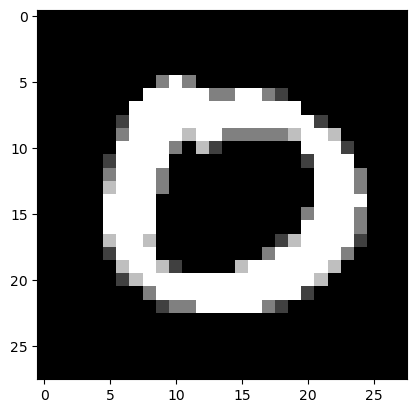

In [70]:
import matplotlib.pyplot as plt

model.eval()

data, target = test_data[9095]

data = data.unsqueeze(0).to(device)

output = model(data)

prediction = output.argmax(dim=1, keepdim=True).item()

print(f'Prediction: {prediction}')

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap='gray')
plt.show
